# U-Net for Brian MRI Segmentation

A brain anomaly is the abnormal growth of some type of tissue in the brain, which can eventually be diagnosed as a tumor. These can be classified according to their growing cell or according to their evolution (malignant, benign or uncertain).

Medical imaging recording systems are used to detect a brain abnormality (or brain tumor). Magnetic resonance imaging (MRI) is the technique used to extract images of this type of tumor. The images generated by MRI enhance different types of information depending on the type of filter used, the filters are: T1, T1 Gd, T2, T2-FLAIR. These filters are time-based measurements of matter's magnetic properties, they help enhance soft and hard tissue, gray matter, and white matter based on time in interaction with the magnetic field generated by the scanner.

Next, a U-Net model will be implemented for the segmentation of brain anomalies in magnetic resonance images with a FLAIR filter.

## Libreries

In [ ]:
!pip install tensorflow-addons==0.16.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os 
from glob import glob
from tqdm import tqdm

import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, metrics
from tensorflow.keras import Input, Model
import tensorflow_addons as tfa

print(f"La version de Tensorflow es {tf.__version__}. Pueden Diferir algunas funciones!")

ModuleNotFoundError: ignored

## ETL

We will create a function called 'get_images_path' to get the directories of medical images and their segmentation masks. A second function called 'read_images' uses the obtained directories to load the medical images (with the 'read_image' function) and the masks (with the 'read_mask' function).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%%time
root = '/content/gdrive/MyDrive/ENM-5310 Data modelling/Project/kaggle_3m'

def get_images_path():
    images = []
    labels = []
    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters): 
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels

def read_images(paths, tipefile):
    images = []
    
    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)    
    else:
        
        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)
    
    imgs1 = np.array(images)
    
    return imgs1
    
#  
def read_image(path):
    
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 12.2 µs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
imgs, labels = get_images_path()
images = read_images(imgs, 'images')
masks = read_images(labels, 'masks')

100%|██████████| 3929/3929 [12:26<00:00,  5.26it/s]


## Data Visualization

We will display 5 random images. The graph consists of the medical image together with its respective segmentation map.

In [ ]:
def plot_image(image, mask):
    plt.figure(figsize=(7, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')

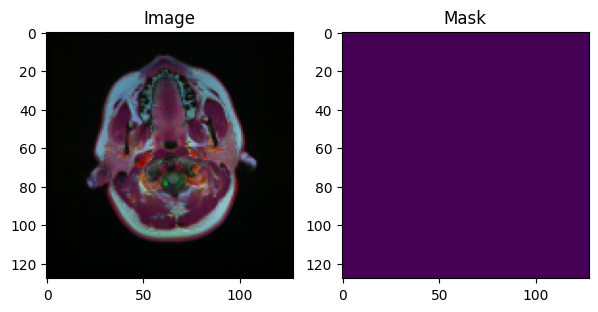

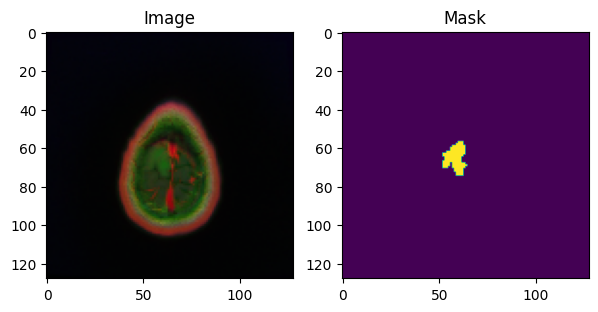

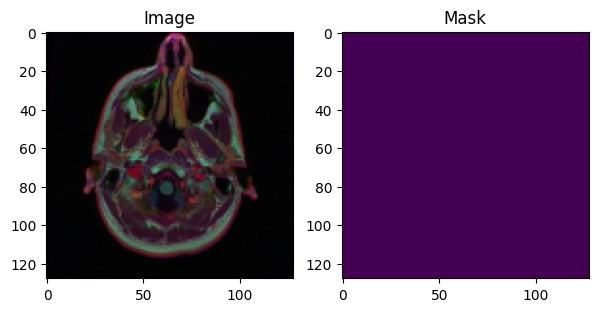

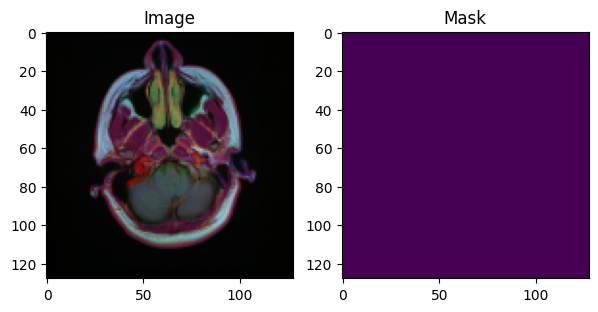

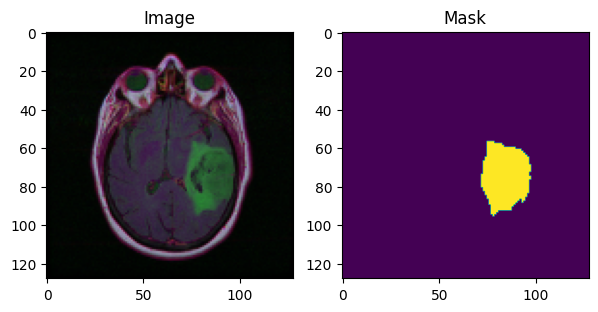

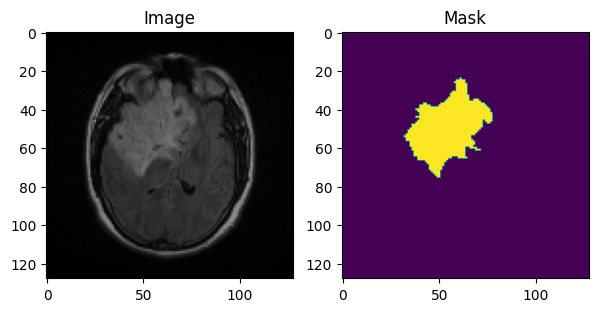

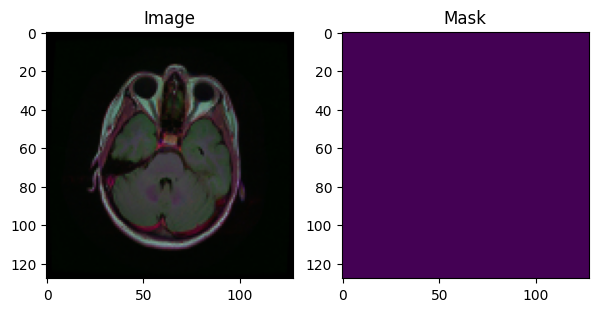

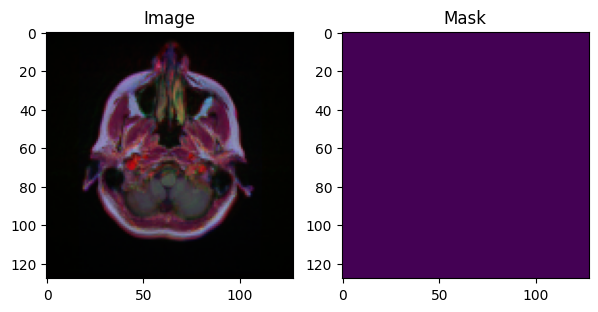

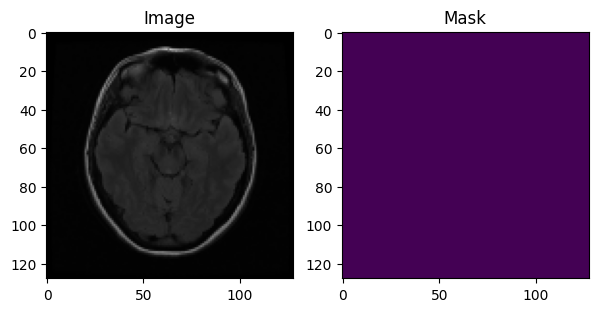

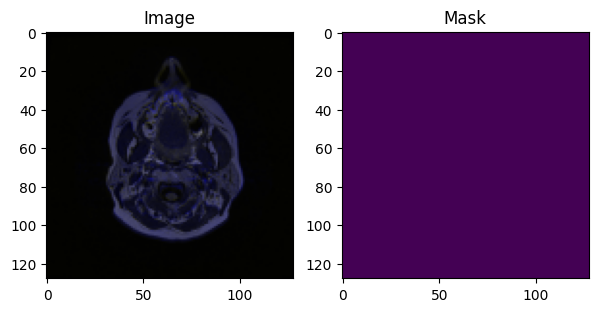

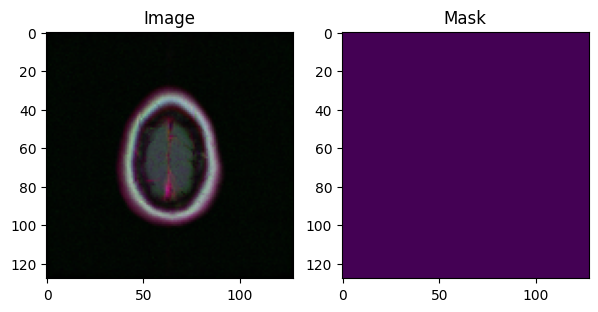

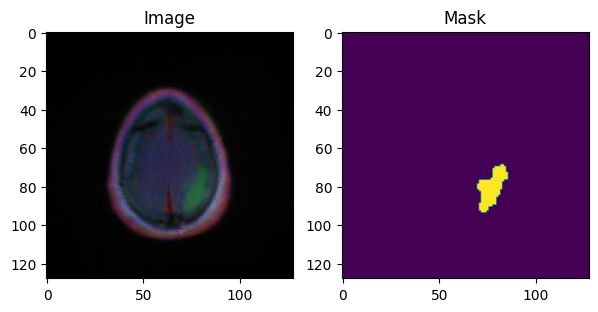

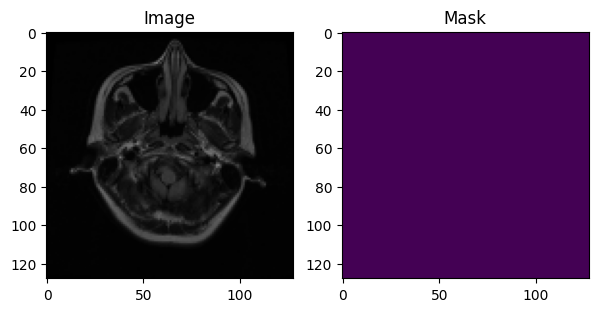

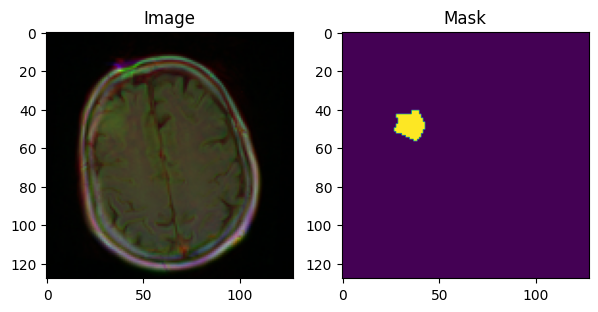

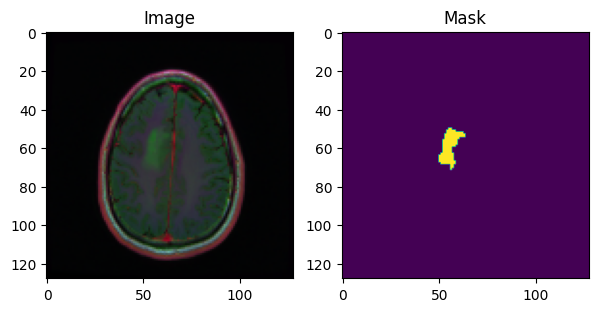

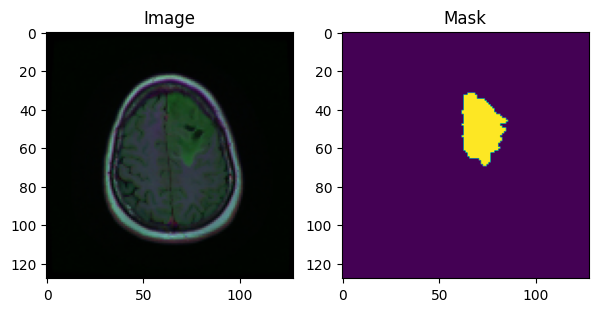

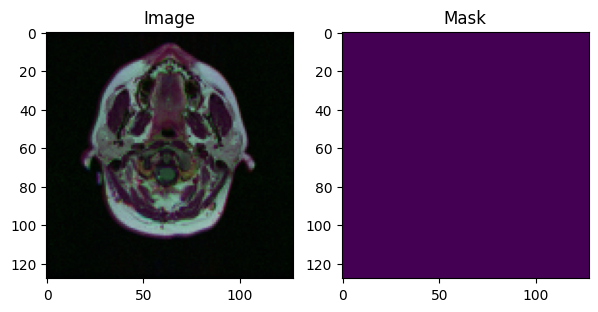

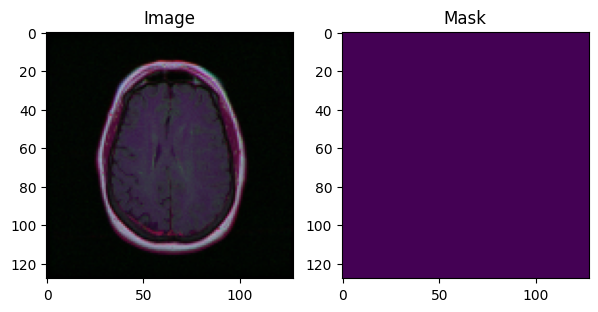

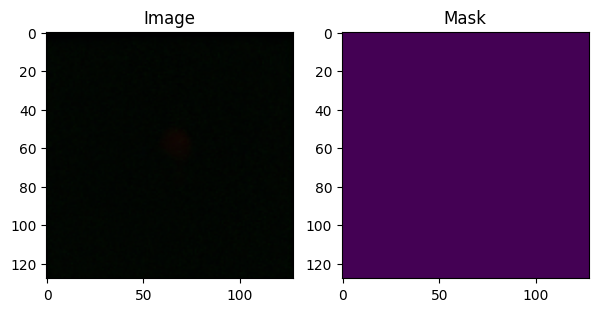

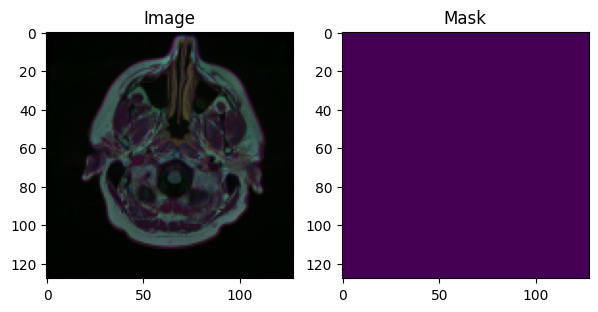

In [ ]:
l = [random.randint(0,1000) for _ in range(20)]

for i in l:
    plot_image(images[i], masks[i])

For best results, we should use only the images in which there are brain abnormalities. We can make this distinction since the sum of the pixels of the segmentations is $0$ if there is no segmentation. As a result, we have 1,373 images with brain abnormalities.

In [ ]:
instance = []
for i in range(masks.shape[0]):
    
    if sum(sum(masks[i])) == 0:
        instance.append('neg')
    else:
        instance.append('pos')


In [ ]:
count = 0
for i in range(len(instance)):
    if instance[i] == 'pos':
        count += 1
print('Number of positive cases: ', count)

count = 0
for i in range(len(instance)):
    if instance[i] == 'neg':
        count += 1
print('Number of negative casess: ', count)

Número de casos positivos:  1373
Número de casos negativos:  2556


In [ ]:
n = images.shape[0]

images_pos = []
masks_pos = []

for i in range(n):
    if instance[i] == 'pos':
        images_pos.append(images[i])
        masks_pos.append(masks[i])
        
images_pos = np.array(images_pos)
masks_pos = np.array(masks_pos)

print('Number of Images ',images_pos.shape)
print('Number of Masks ',masks_pos.shape)


Número de imágenes  (1373, 128, 128, 3)
Número de mascaras  (1373, 128, 128, 1)


Now we visualize the positive cases that we will use.

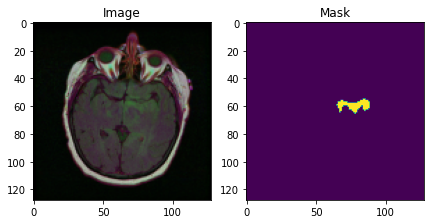

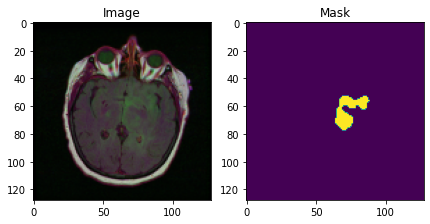

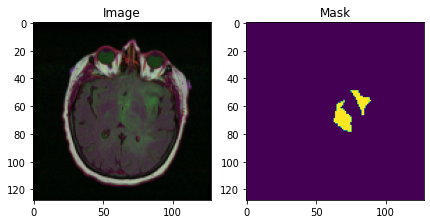

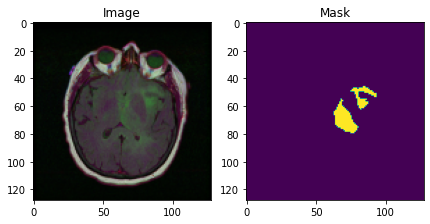

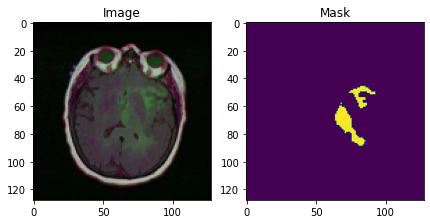

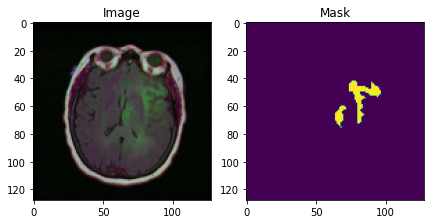

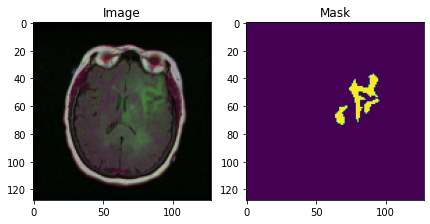

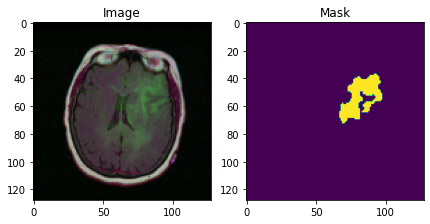

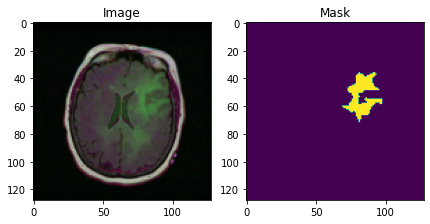

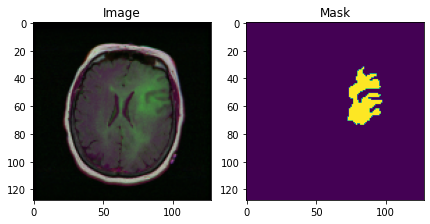

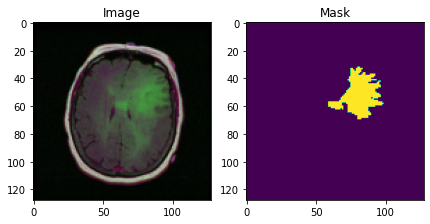

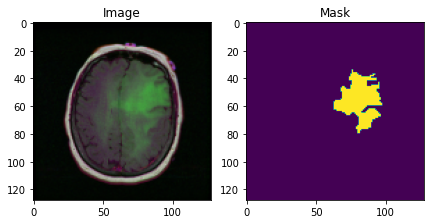

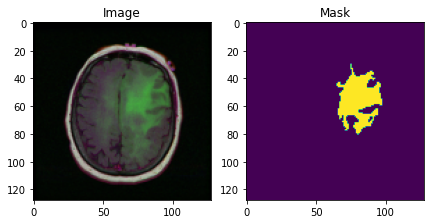

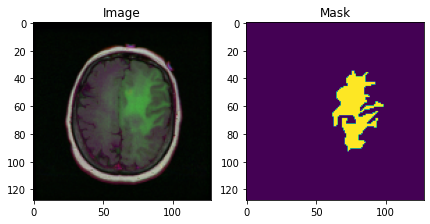

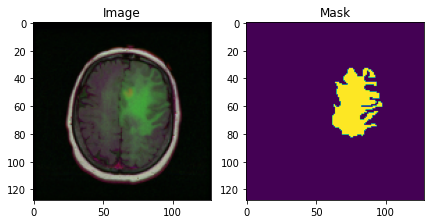

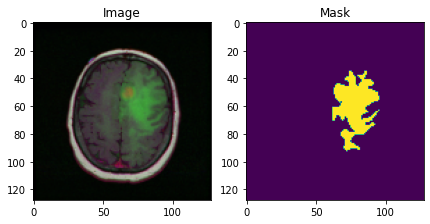

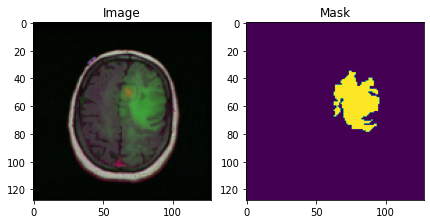

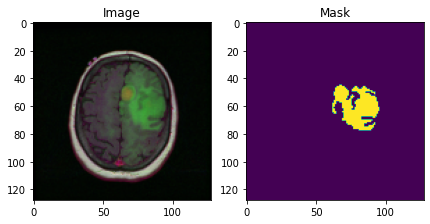

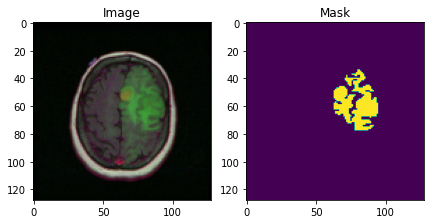

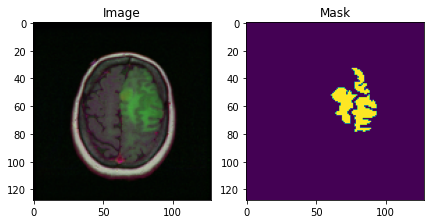

In [ ]:
for i in range(20):
    plot_image(images_pos[i],masks_pos[i])

## Preparing Image for traning

Since we have the images and segmentation maps in different lists, we can separate the dataset into training, validation and test. Each observation consists of a medical image and a segmentation map. The training dataset contains 1,029 observations, the validation dataset contains 172 observations, the test dataset contains 172 observations. Images and maps are of size $128\times128$ px. Images have 3 channels and maps 1.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_pos, masks_pos, test_size = .25, random_state = 288)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .50, random_state = 288)

In [ ]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_val shape:   ',  X_val.shape)
print('X_test shape:  ',  X_test.shape)
print('\n')
print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_val shape:   ',  y_val.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (1029, 128, 128, 3)
X_val shape:    (172, 128, 128, 3)
X_test shape:   (172, 128, 128, 3)


########## Masks ##########
y_train shape:  (1029, 128, 128, 1)
y_val shape:    (172, 128, 128, 1)
y_test shape:   (172, 128, 128, 1)


## U-Net

![](https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png)

U-Net is a training strategy that consists of building a segmentation map using different levels of abstraction from the information contained in the input images. The U-Net architecture consists of an encoder and a decoder. The encoder is in charge of extracting relevant features from the images and the decoder is in charge of generating the segmentation map from the features extracted in the encoder.

We start by creating a convolutional block, this consists of two 2D convolutions, with a kernel size of $3\times3$ and a ReLu activation. Also, adding a layer of batch normalization in each convolution.

In [ ]:
def create_conv_block(input_tensor, num_filters):
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

Using the convolutional block created above we build the U-Net architecture. Starting with the encoder, using 4 convolutional blocks reduces the size of the image from $150\times150$ to $16\times16$ pixels.

In [ ]:
def create_unet(input_shape, num_filters=16, dropout=0.1):
    # Encoder
    
    c1 = create_conv_block(input_shape, num_filters * 1)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = create_conv_block(p1, num_filters * 2)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = create_conv_block(p2, num_filters * 4)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)

    c4 = create_conv_block(p3, num_filters * 8)
    
    # Decoder
    
    u5 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5, c3])
    u5 = tf.keras.layers.Dropout(dropout)(u5)
    c5 = create_conv_block(u5, num_filters*4)
    
    u6 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c2])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = create_conv_block(u6, num_filters*2)
    
    u7 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c1])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = create_conv_block(u7, num_filters*1)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    model = tf.keras.Model(inputs = [input_shape], outputs = [output])
    
    return model 

In [ ]:
inputs = tf.keras.layers.Input((128, 128, 3))
model = create_unet(inputs)

2023-01-06 21:48:34.596813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 21:48:34.855229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 21:48:34.856124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 21:48:34.858652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

Plotting the model in the following way allows us to better observe the encoder and decoder and their sizes.

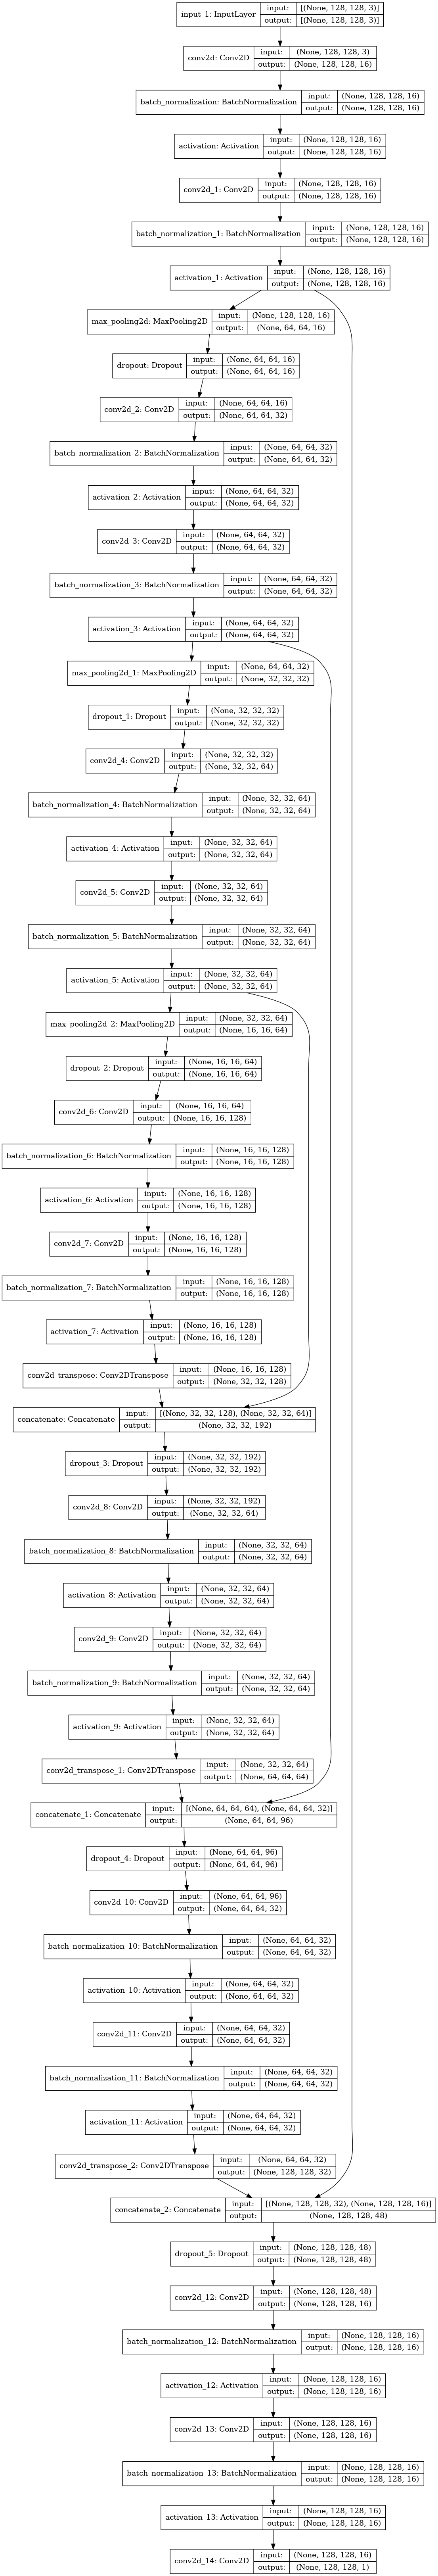

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)]

In [ ]:
model_history = model.fit(X_train, 
                          y_train,
                          verbose = 1,
                          epochs = 100,
                          validation_data = (X_val, y_val),
                          callbacks = my_callbacks)

2023-01-06 21:48:41.401704: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-06 21:48:44.224054: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 12s 95ms/step - loss: 0.5697 - accuracy: 0.7360 - val_loss: 13.7891 - val_accuracy: 0.1049
Epoch 2/100
33/33 [==============================] - 2s 68ms/step - loss: 0.2949 - accuracy: 0.9736 - val_loss: 1.6373 - val_accuracy: 0.3652
Epoch 3/100
33/33 [==============================] - 2s 69ms/step - loss: 0.2347 - accuracy: 0.9780 - val_loss: 0.4875 - val_accuracy: 0.9239
Epoch 4/100
33/33 [==============================] - 2s 68ms/step - loss: 0.1962 - accuracy: 0.9794 - val_loss: 0.3087 - val_accuracy: 0.9724
Epoch 5/100
33/33 [==============================] - 2s 71ms/step - loss: 0.1661 - accuracy: 0.9798 - val_loss: 0.2463 - val_accuracy: 0.9725
Epoch 6/100
33/33 [==============================] - 2s 69ms/step - loss: 0.1433 - accuracy: 0.9806 - val_loss: 0.1975 - val_accuracy: 0.9726
Epoch 7/100
33/33 [==============================] - 2s 68ms/step - loss: 0.1242 - accuracy: 0.9825 - val_loss: 0.1615 - val_accuracy: 0.9734
Epoch 8/100
33/3

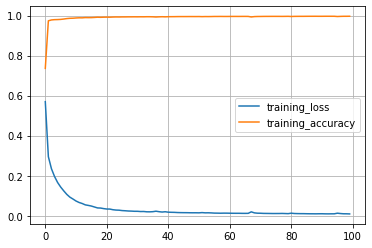

In [ ]:
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['accuracy'], label='training_accuracy')
plt.legend()
plt.grid(True)

Now we will perform the predictions and then transform the segmentation mask into an array of $0$s and $1$s.

In [ ]:
def predict_test_samples(X_test, y_test, model):
    test_images = np.array(X_test)

    predictions = model.predict(test_images)

    return predictions, test_images, y_test

In [ ]:
def plot_images(test_image, predicted_maks, ground_truth):
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_maks)
    plt.title('Predicted mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title('Ground truth mask')

In [ ]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(X_test, y_test, model)

In [ ]:
# Cambiar valores de mas mascaras a 0s y 1s
for i in range(predicted_masks.shape[0]):
    for j in range(predicted_masks.shape[1]):
        for k in range(predicted_masks.shape[2]):
            if predicted_masks[i,j,k] > .5:
                predicted_masks[i,j,k] = 1
            else:
                predicted_masks[i,j,k] = 0

In [ ]:
def dice_coefficient(ground_truth_masks, predicted_masks, smooth=1):
    intersection = tf.reduce_sum(ground_truth_masks * predicted_masks, axis=[1, 2, 3])
    union = tf.reduce_sum(ground_truth_masks, axis=[1, 2, 3]) + tf.reduce_sum(predicted_masks, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

Dice = float(dice_coefficient(ground_truth_masks, predicted_masks, smooth=15))

print('Dice score', Dice)

Dice score 0.8424764275550842


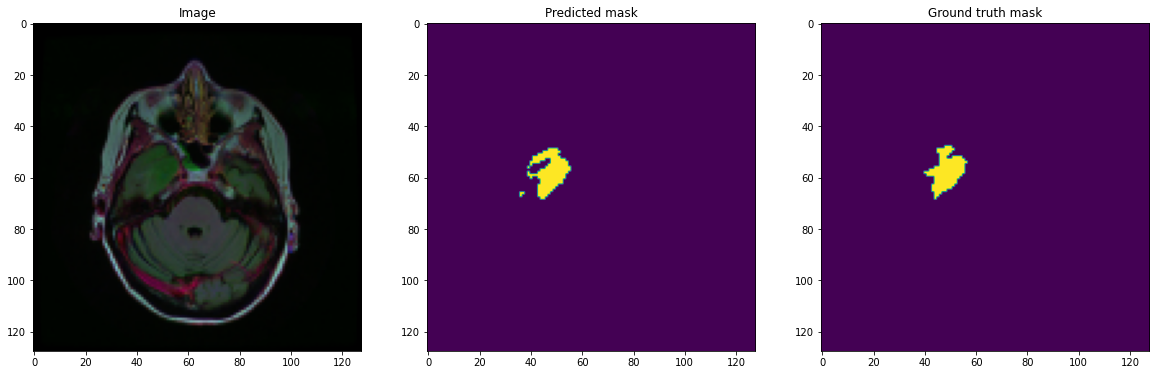

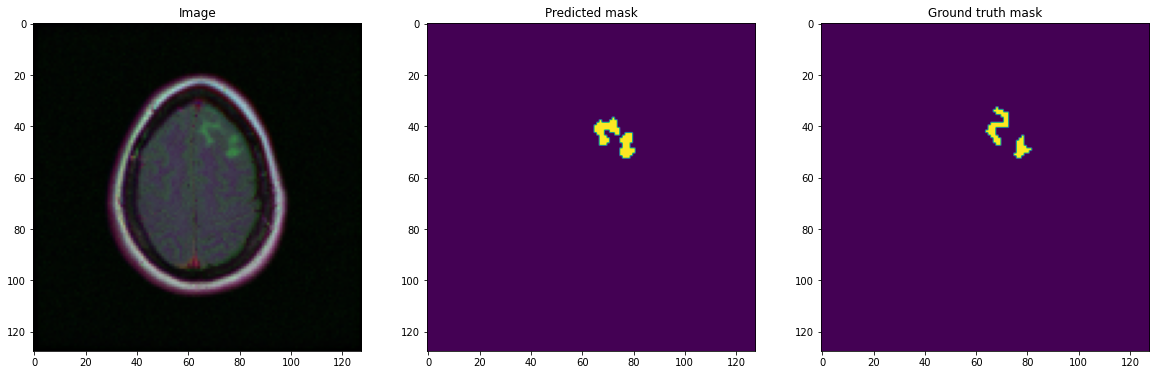

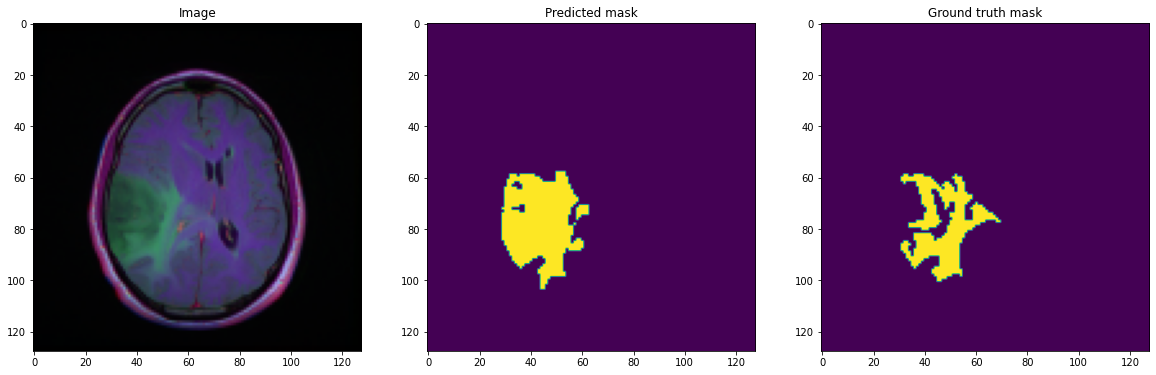

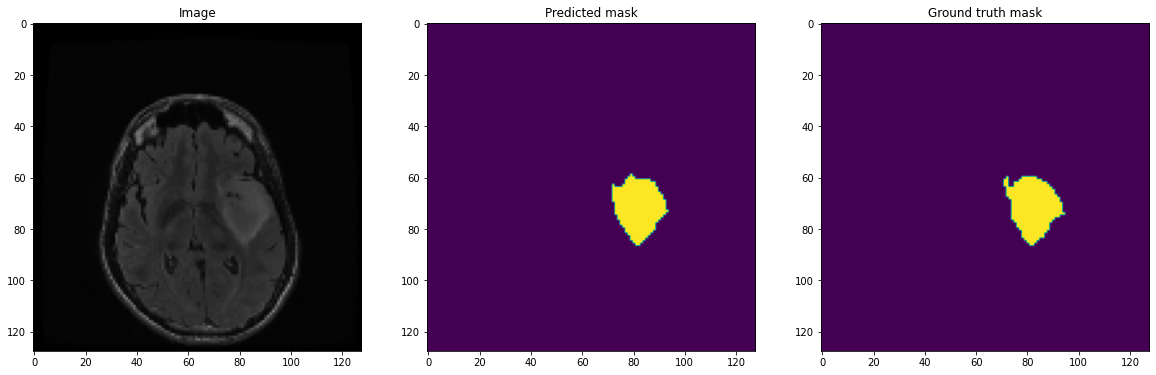

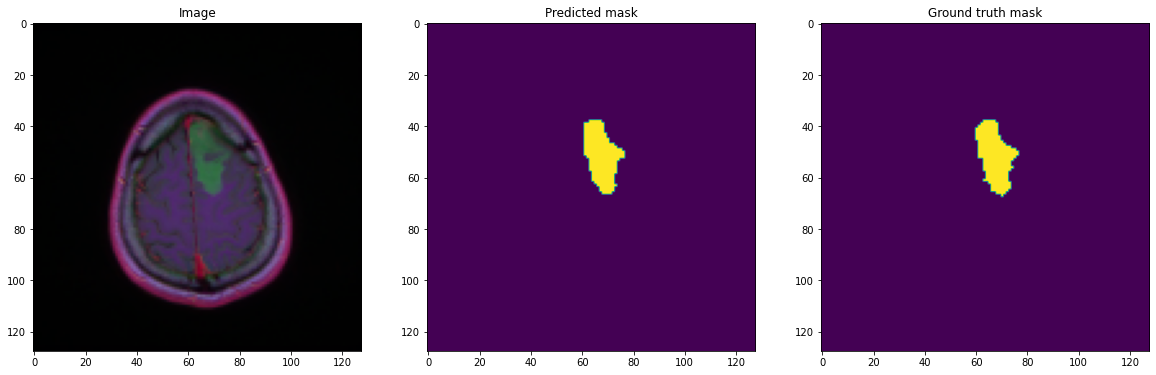

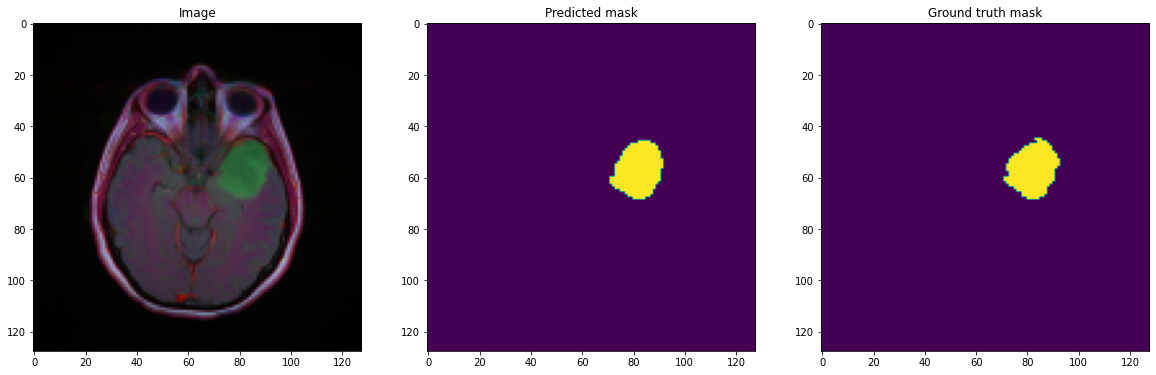

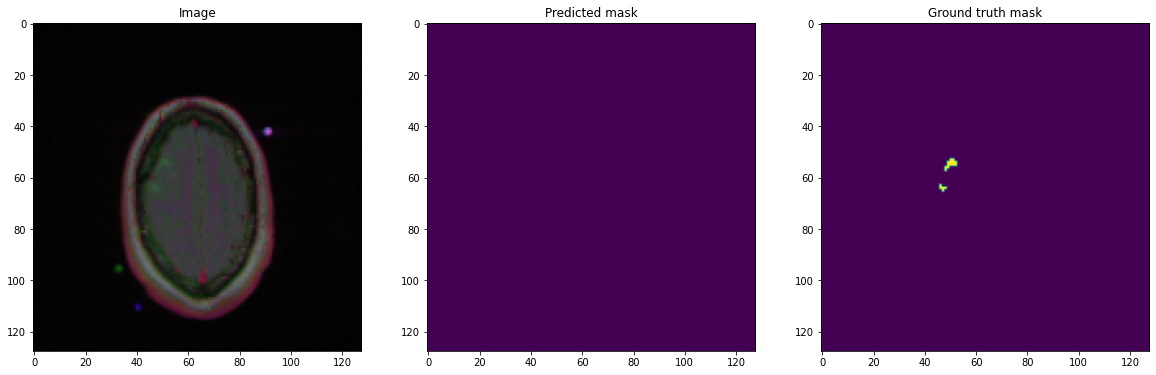

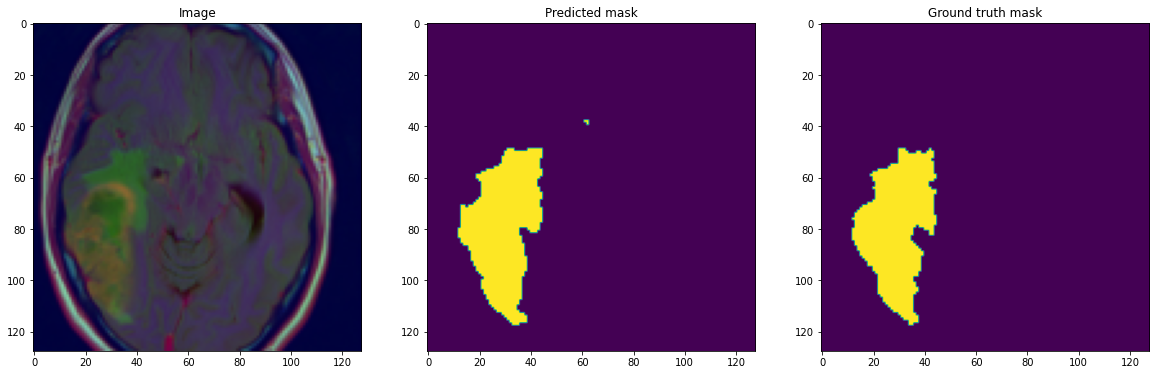

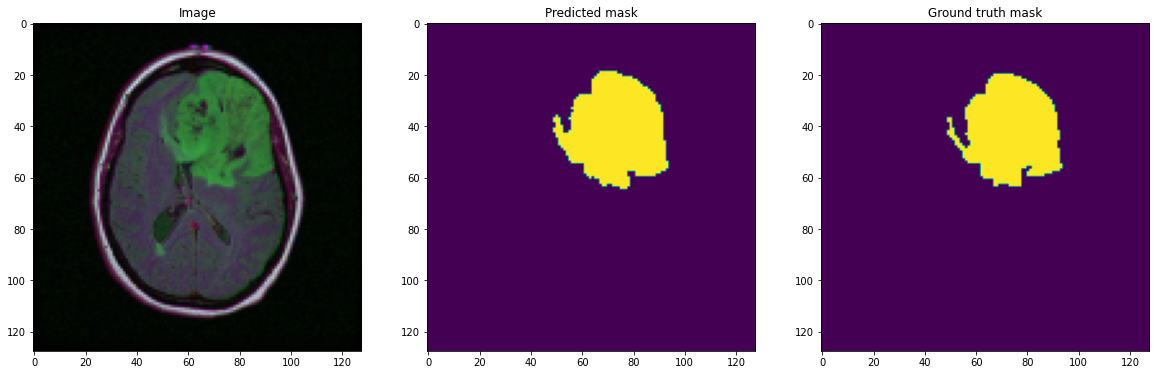

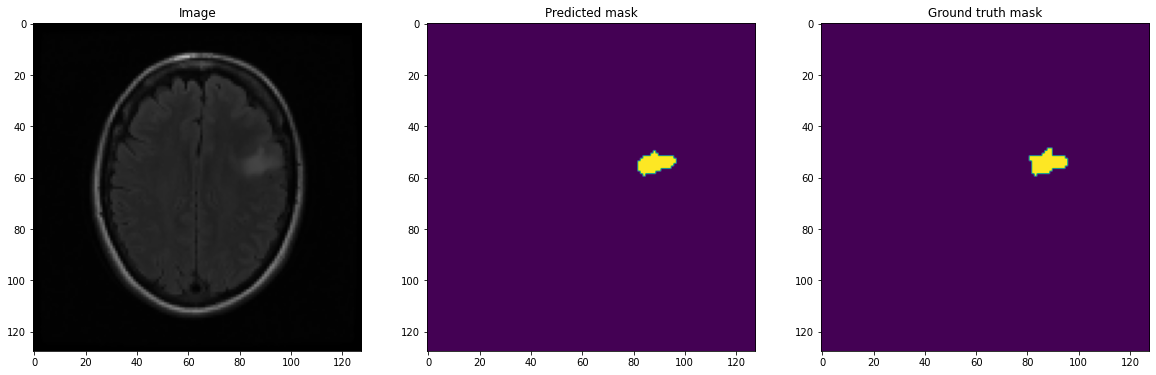

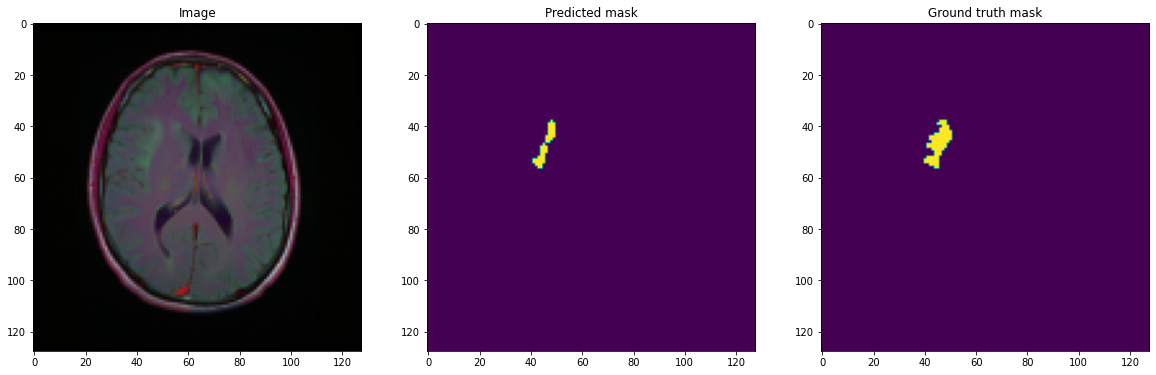

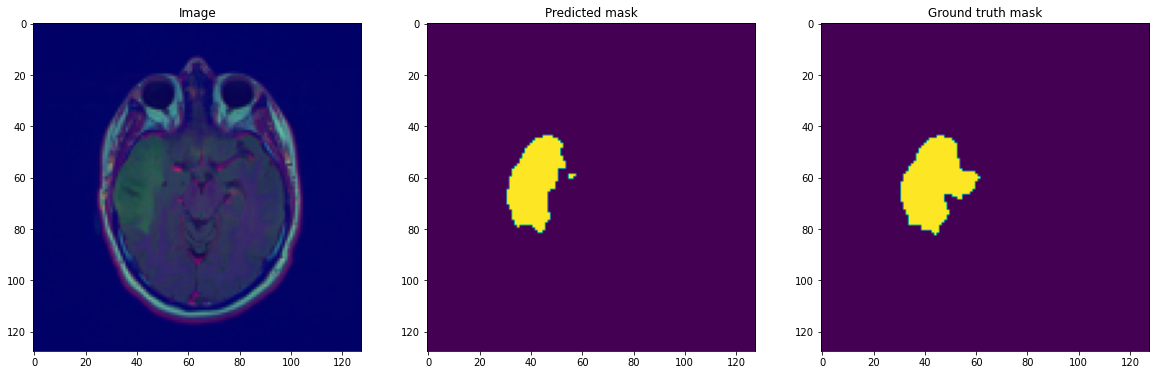

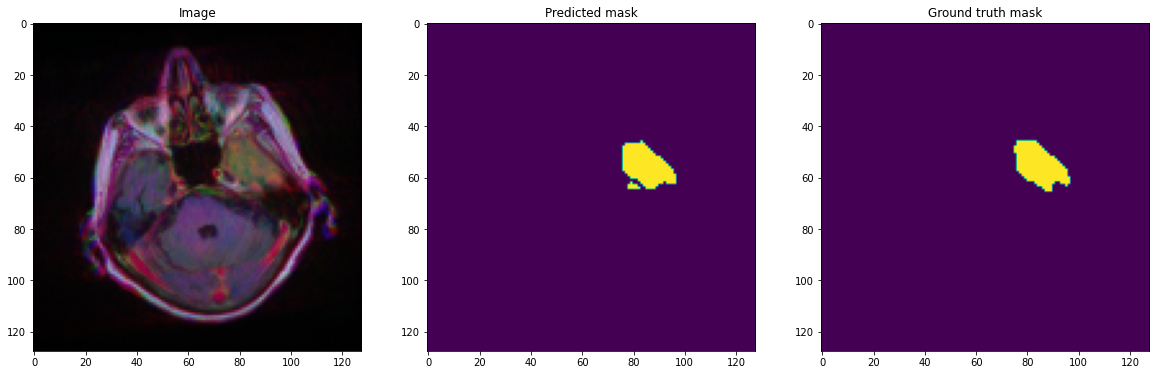

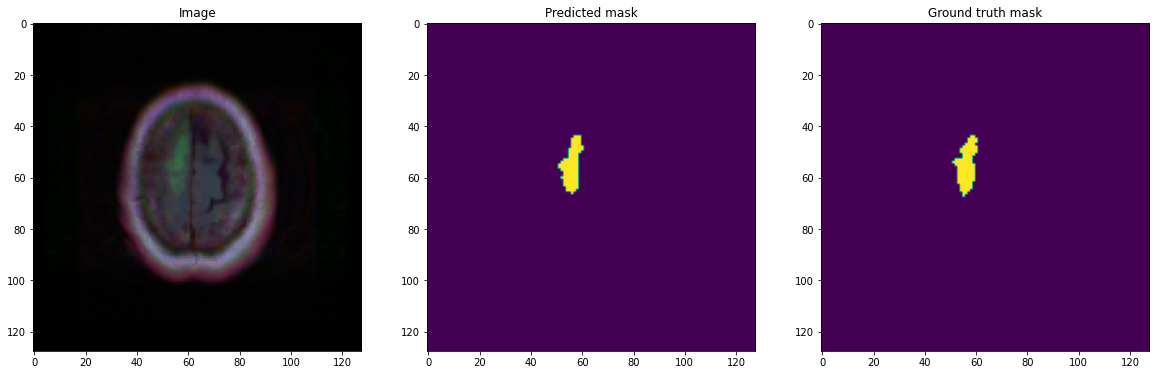

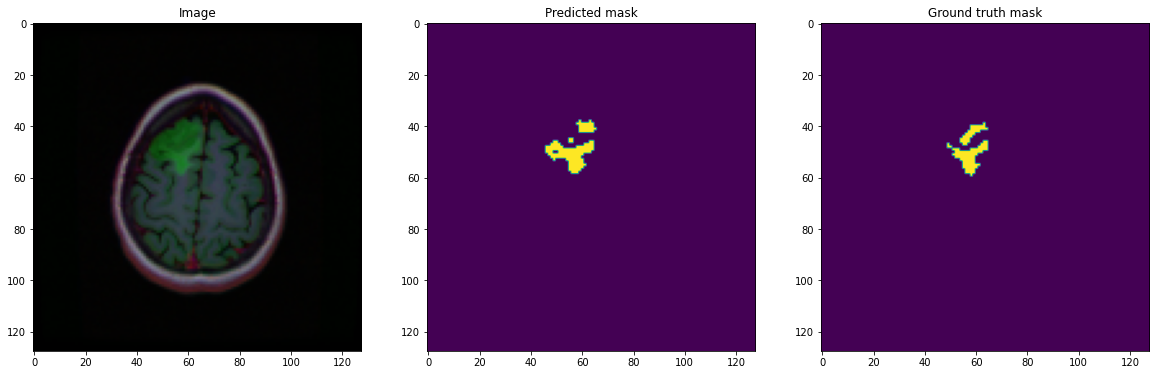

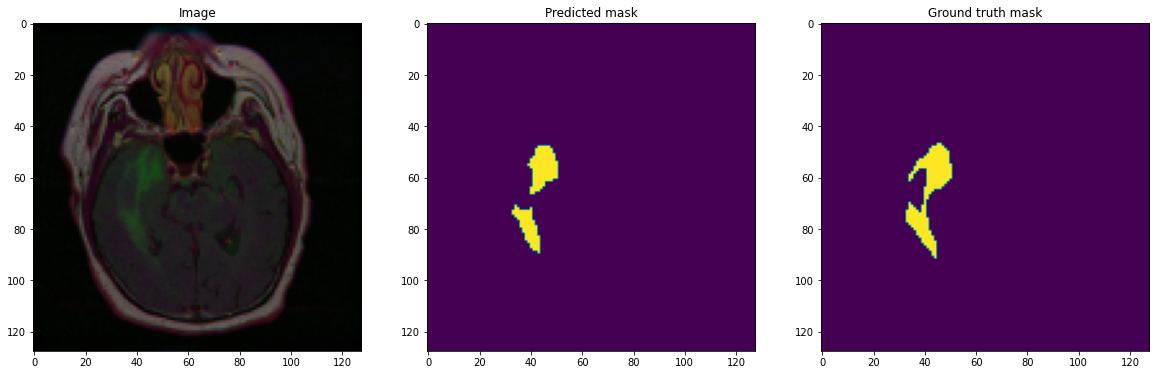

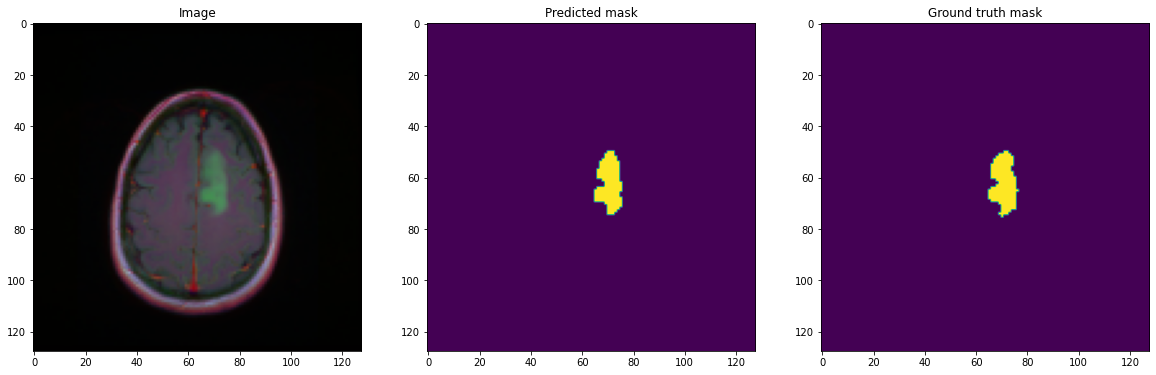

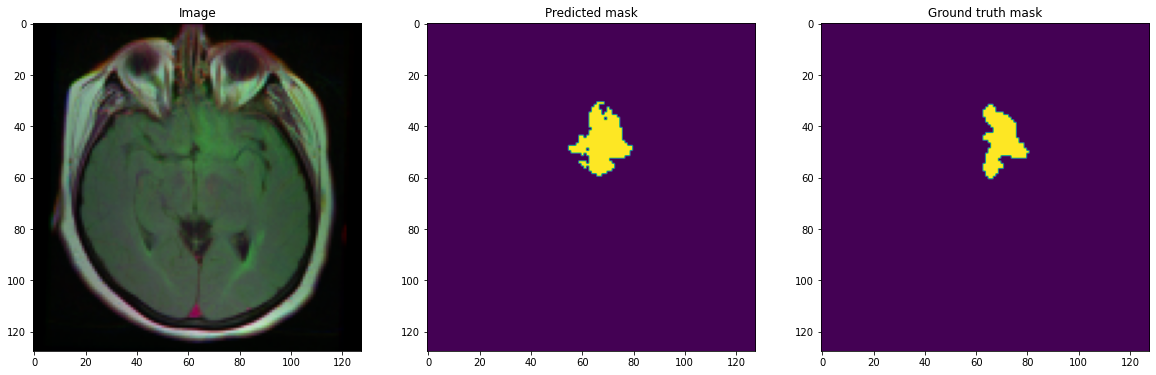

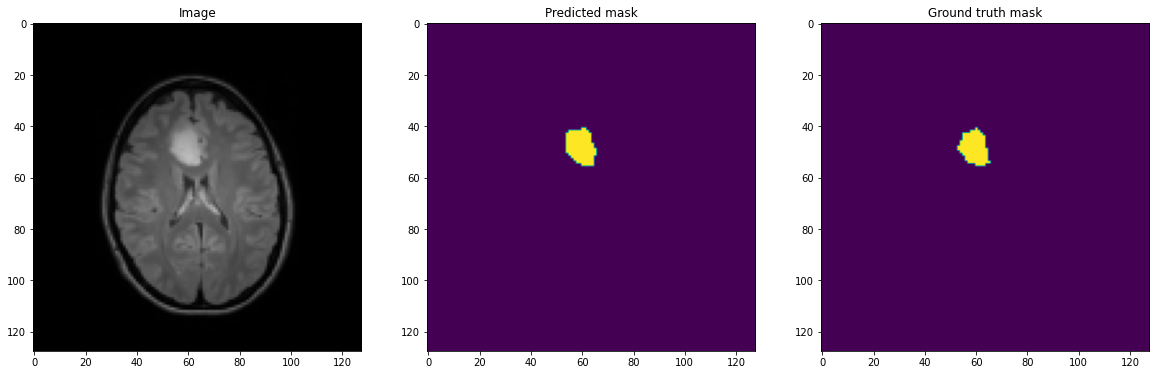

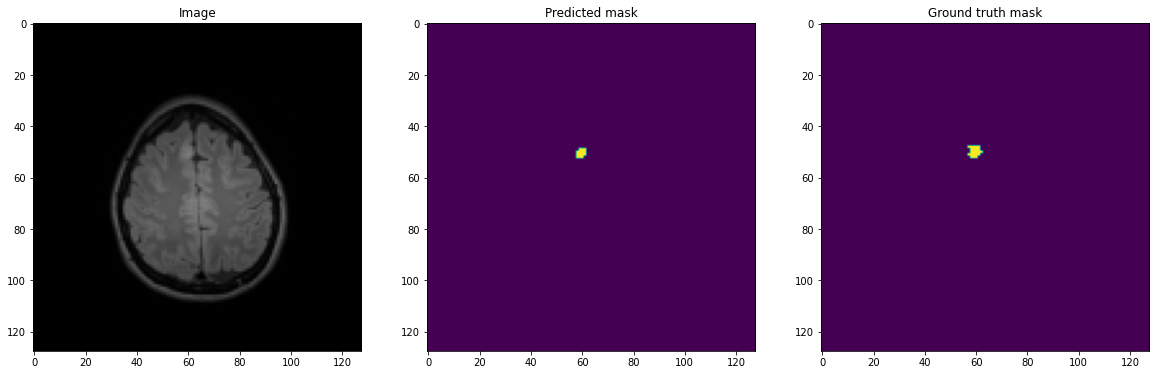

In [ ]:
for idx in range(0, 20):
    plot_images(test_images[idx], predicted_masks[idx], ground_truth_masks[idx])

# Model II

In [ ]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_val shape:   ',  X_val.shape)
print('X_test shape:  ',  X_test.shape)

print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_val shape:   ',  y_val.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (1029, 128, 128, 3)
X_val shape:    (172, 128, 128, 3)
X_test shape:   (172, 128, 128, 3)
########## Masks ##########
y_train shape:  (1029, 128, 128, 1)
y_val shape:    (172, 128, 128, 1)
y_test shape:   (172, 128, 128, 1)


In [ ]:
imsize = [128,128,1]
batch_size = 12
n_epochs = 200
learning_rate = 1e-4
weight_decay= 1e-5

train_steps = X_train.shape[0] // batch_size
valid_steps = X_val.shape[0] // batch_size

In [ ]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation=activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [ ]:
def create_unet(image_size, widths, block_depth):
    input_image = Input(shape=imsize)
    x = layers.Conv2D(widths[0], kernel_size=1)(input_image)
    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])
    
    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)
    
    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])
    
    out = layers.Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    
    return Model(inputs=input_image, outputs=out, name="UNet")

In [ ]:
# As a cost function, we will combine a soft-dice score with the cross-entropy weighted by a beta parameter.

def combined_loss():
    def convert_to_logits(y_pred):
        #Como nuestro modelo entrega probabilidad, debemos retornarlo a logits
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1-tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))
    
    def loss(y_true, y_pred, beta):
        y_pred = convert_to_logits(y_pred)
        pos_weight = beta / (1-beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred,
            labels=y_true,
            pos_weight=pos_weight,
        )
        return tf.reduce_mean(loss * (1-beta))
    
    def dice_loss(y_true, y_pred):
        numerator = 2. * tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1,2])
        denominator = tf.reduce_sum(tf.add(y_true, y_pred), axis=[1,2])
        x = tf.math.divide_no_nan(numerator, denominator)
        return tf.reduce_mean(1 - x)
    
    def combined(y_true, y_pred,):
        return 0.5*dice_loss(y_true, y_pred) + 0.5*loss(y_true, y_pred, 0.8)
    
    return combined

In [ ]:
# Let's create a Metric as a class
class DiceScore(metrics.Metric):
    def __init__(self, name="DiceScore", **kwargs):
        super(DiceScore, self).__init__(name=name, **kwargs)
        self.mean_dice = metrics.Mean(name="DiceScore_Tracker")
    
    def update_state(self, real, pred, sample_weight=None):
        numerator = 2. * tf.reduce_sum(tf.multiply(real, pred), axis=[1,2])
        denominator = tf.reduce_sum(tf.add(real, pred), axis=[1,2])
        x = tf.math.divide_no_nan(numerator, denominator)
        x = tf.reduce_mean(x)
        self.mean_dice.update_state(x)
    
    def result(self):
        return self.mean_dice.result()

    def reset_state(self):
        self.mean_dice.reset_state()

In [ ]:
widths = [32, 64, 128, 256, 512]
block_depth = 2

In [ ]:
initial_learning_rate = learning_rate
decay_steps =train_steps*int(0.85*n_epochs)
alpha = 1e-3


def decayed_learning_rate(step):
    step = np.minimum(step, decay_steps)
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    return initial_learning_rate * decayed

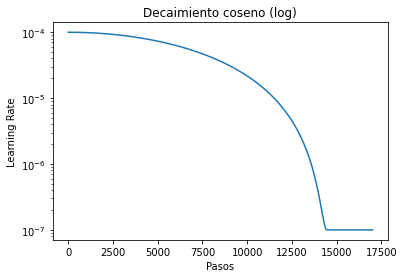

In [ ]:
steps = np.arange(0, train_steps*n_epochs)
y = decayed_learning_rate(steps)

fig = plt.figure()
ax = fig.add_subplot()

ax.semilogy(steps, y)
ax.set(
    title='Decaimiento coseno (log)',
    xlabel='Pasos',
    ylabel='Learning Rate'
)
fig.show()

In [ ]:
# If you want to use a static learning_rate, comment the scheduler and uncomment this

# lr = learning_rate
lr = tf.keras.optimizers.schedules.CosineDecay(learning_rate, decay_steps=decay_steps, alpha=alpha)

# AdamW is a more modern version of the Adam Algorithm, with decay weights.
model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
    loss=combined_loss(),
    metrics=[DiceScore()],
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Early Stopping
cbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_DiceScore",
        patience=np.ceil(0.05*n_epochs).astype(int),
        mode="max",
        restore_best_weights=True,
    ),
]

In [ ]:
model_history = model.fit(X_train, 
                          y_train,
                          validation_data = (X_val, y_val),
                          steps_per_epoch = train_steps,
                          validation_steps = valid_steps,
                          epochs = n_epochs,
                          callbacks = cbacks,
)

Epoch 1/200
85/85 [==============================] - 7s 41ms/step - loss: 0.0641 - DiceScore: 0.8759 - val_loss: 0.1065 - val_DiceScore: 0.7968
Epoch 2/200
85/85 [==============================] - 3s 32ms/step - loss: 0.0594 - DiceScore: 0.8842 - val_loss: 0.1053 - val_DiceScore: 0.8005
Epoch 3/200
85/85 [==============================] - 3s 32ms/step - loss: 0.0560 - DiceScore: 0.8913 - val_loss: 0.1028 - val_DiceScore: 0.8048
Epoch 4/200
85/85 [==============================] - 3s 33ms/step - loss: 0.0553 - DiceScore: 0.8935 - val_loss: 0.0990 - val_DiceScore: 0.8120
Epoch 5/200
85/85 [==============================] - 3s 32ms/step - loss: 0.0533 - DiceScore: 0.8972 - val_loss: 0.0995 - val_DiceScore: 0.8124
Epoch 6/200
85/85 [==============================] - 3s 32ms/step - loss: 0.0516 - DiceScore: 0.9006 - val_loss: 0.0990 - val_DiceScore: 0.8137
Epoch 7/200
85/85 [==============================] - 3s 32ms/step - loss: 0.0517 - DiceScore: 0.9015 - val_loss: 0.0993 - val_DiceScore:

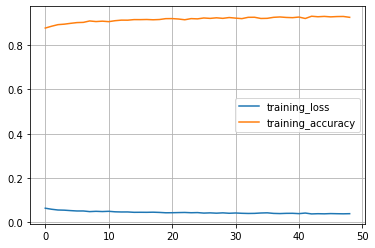

In [ ]:
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['DiceScore'], label='training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
def predict_test_samples(X_test, y_test, model):
    test_images = np.array(X_test)

    predictions = model.predict(test_images)

    return predictions, test_images, y_test

In [ ]:
def plot_images(test_image, predicted_maks, ground_truth):
    plt.figure(figsize=(20, 20))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title('Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_maks)
    plt.title('Predicted mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title('Ground truth mask')

In [ ]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(X_test, y_test, model)

In [ ]:
np.unique(predicted_masks[0])

array([3.6004415e-06, 4.2878605e-06, 4.8986858e-06, ..., 9.9999940e-01,
       9.9999952e-01, 9.9999964e-01], dtype=float32)

In [ ]:
# Cambiar valores de mas mascaras a 0s y 1s
for i in range(predicted_masks.shape[0]):
    for j in range(predicted_masks.shape[1]):
        for k in range(predicted_masks.shape[2]):
            if predicted_masks[i,j,k] > .5:
                predicted_masks[i,j,k] = 1
            else:
                predicted_masks[i,j,k] = 0

In [ ]:
def dice_coefficient(ground_truth_masks, predicted_masks, smooth=1):
    intersection = tf.reduce_sum(ground_truth_masks * predicted_masks, axis=[1, 2, 3])
    union = tf.reduce_sum(ground_truth_masks, axis=[1, 2, 3]) + tf.reduce_sum(predicted_masks, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

Dice = float(dice_coefficient(ground_truth_masks, predicted_masks, smooth=15))

print('Dice score', Dice)

Dice score 0.844815194606781


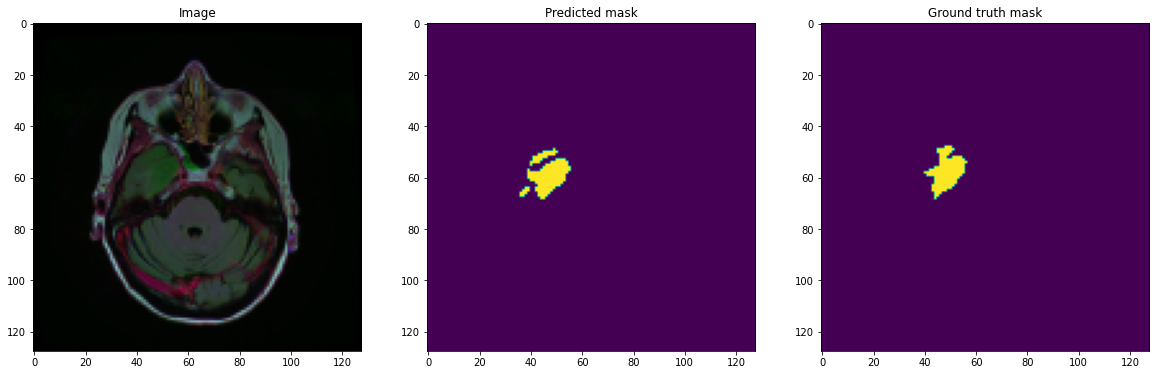

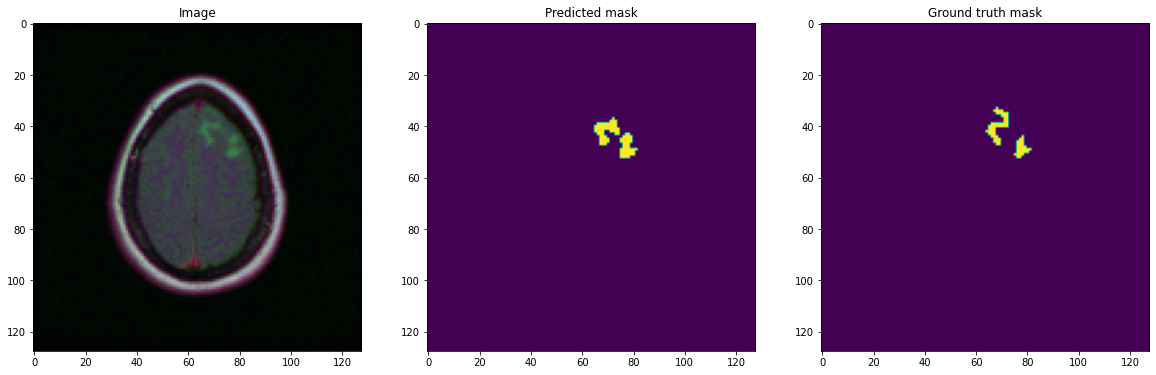

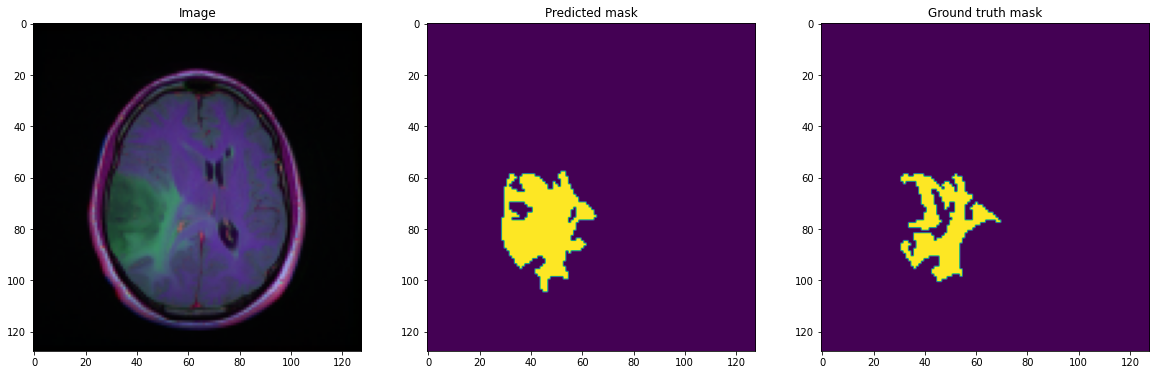

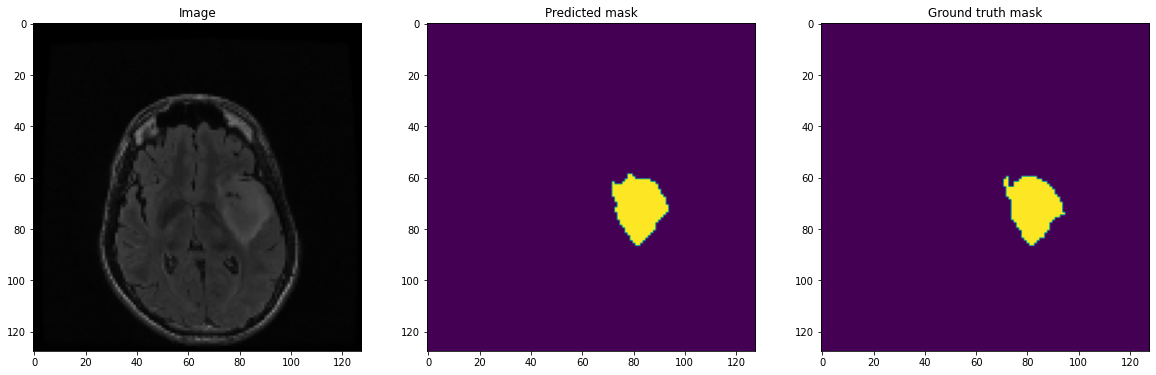

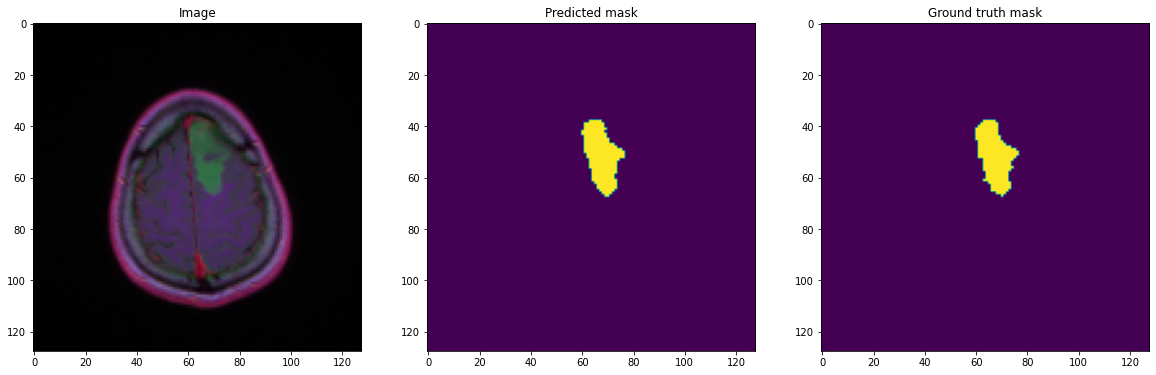

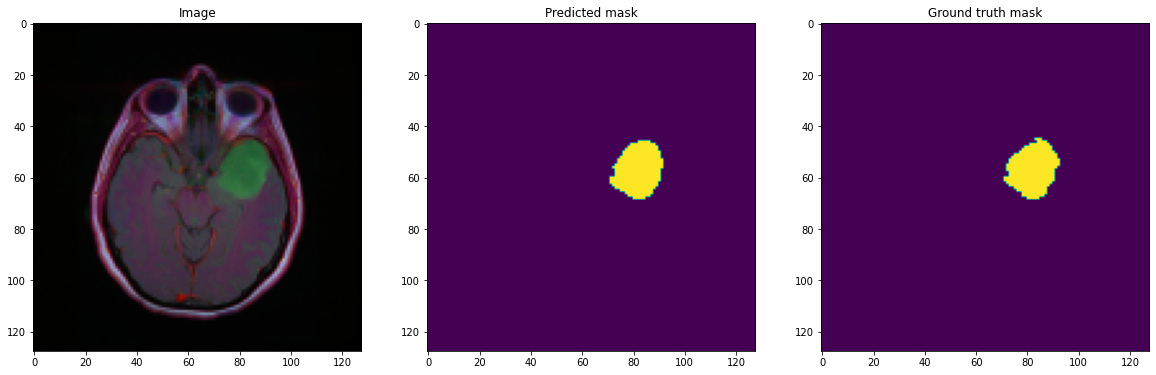

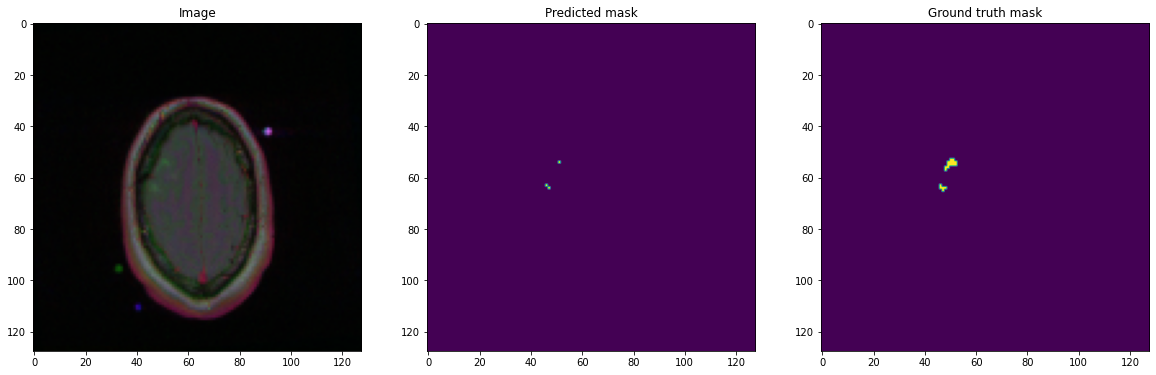

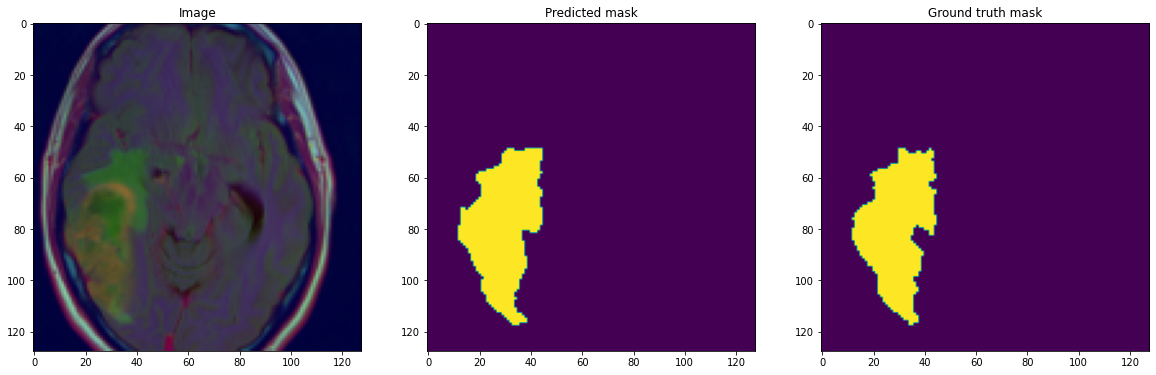

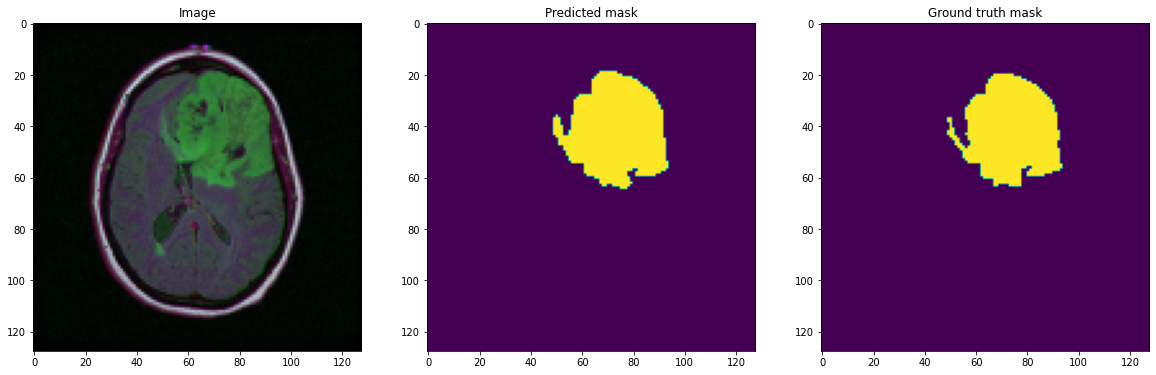

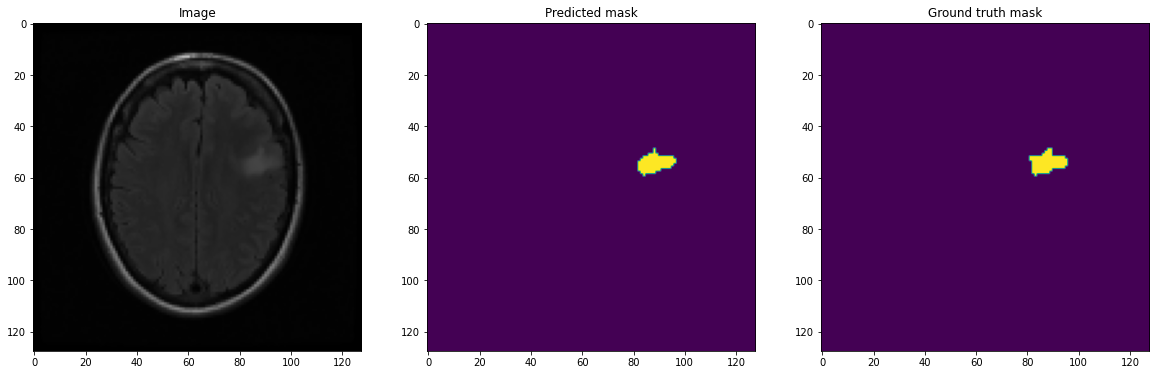

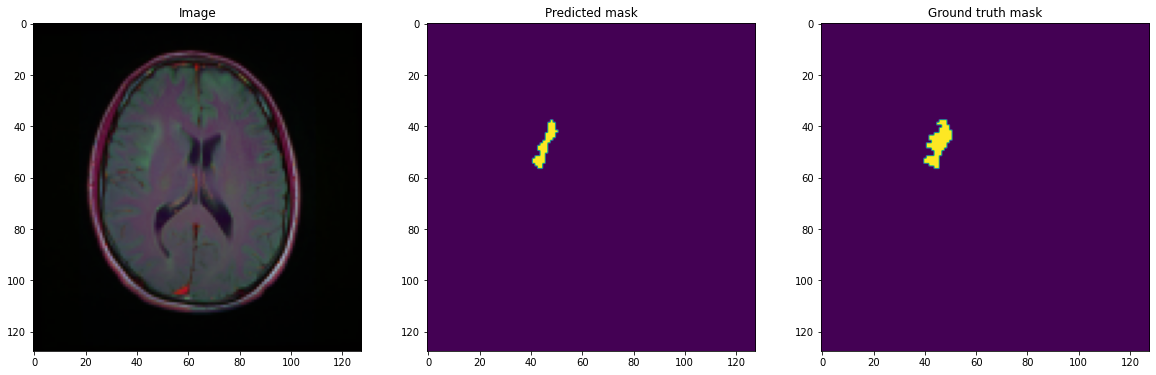

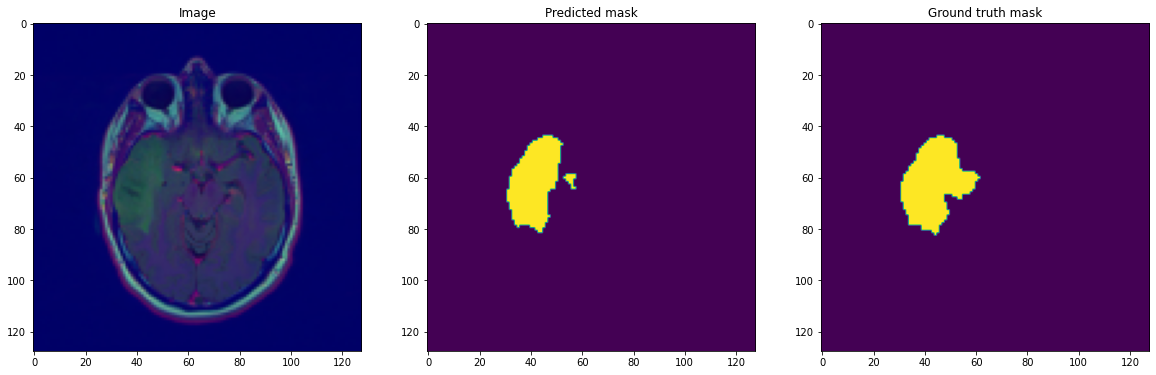

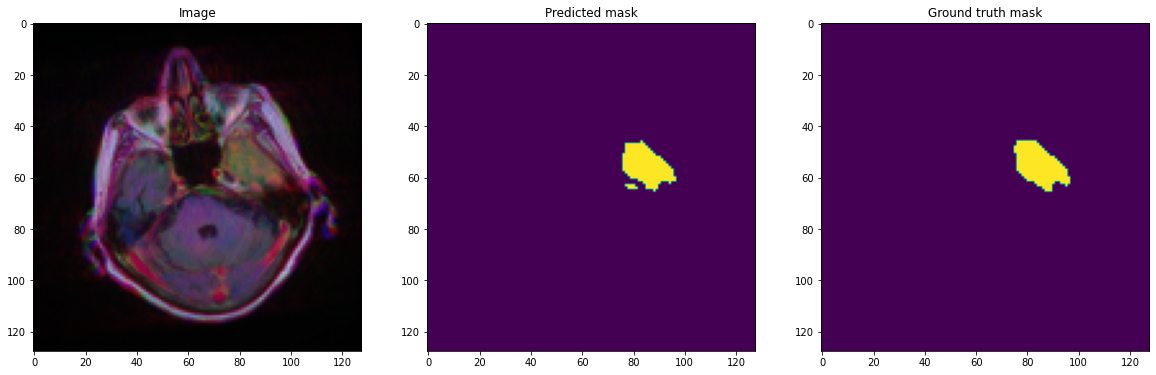

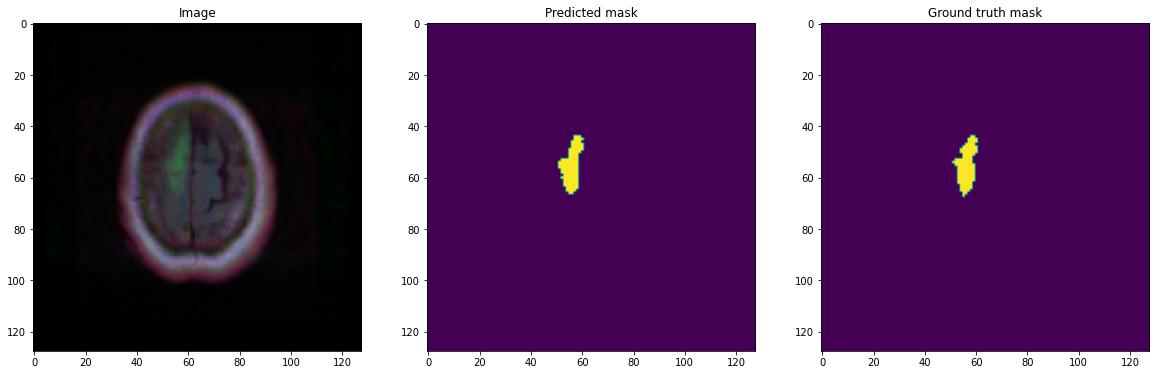

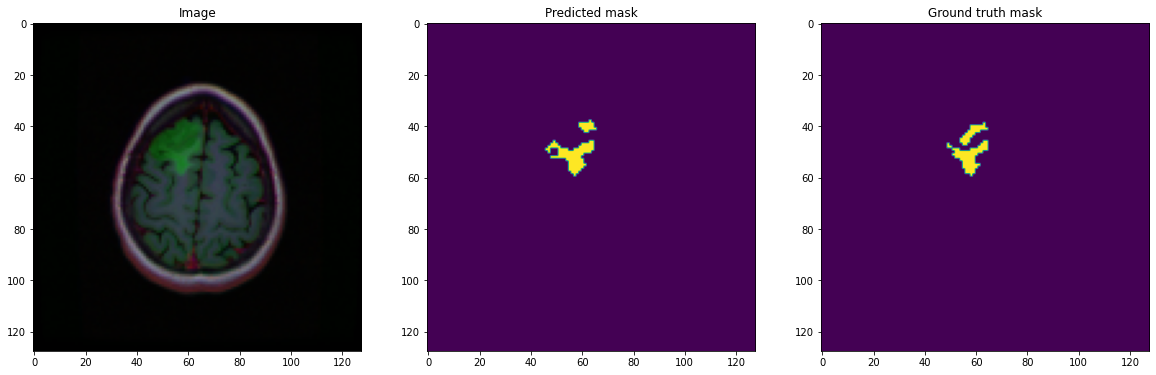

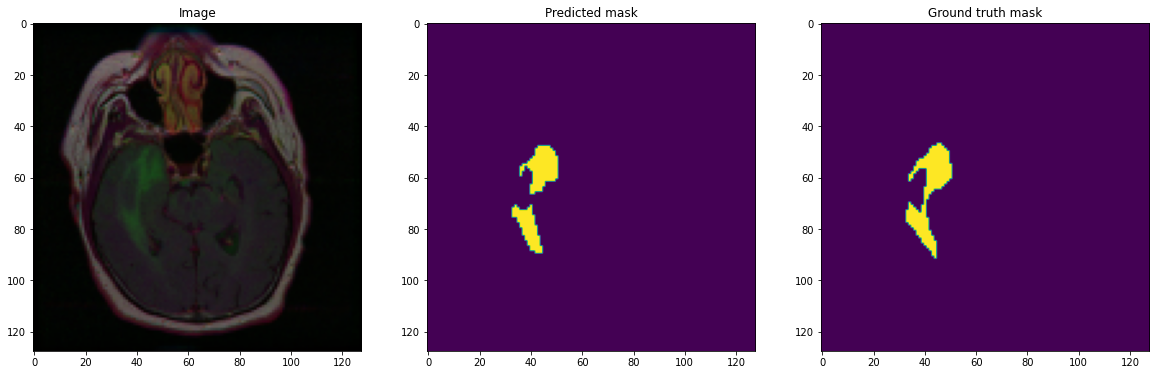

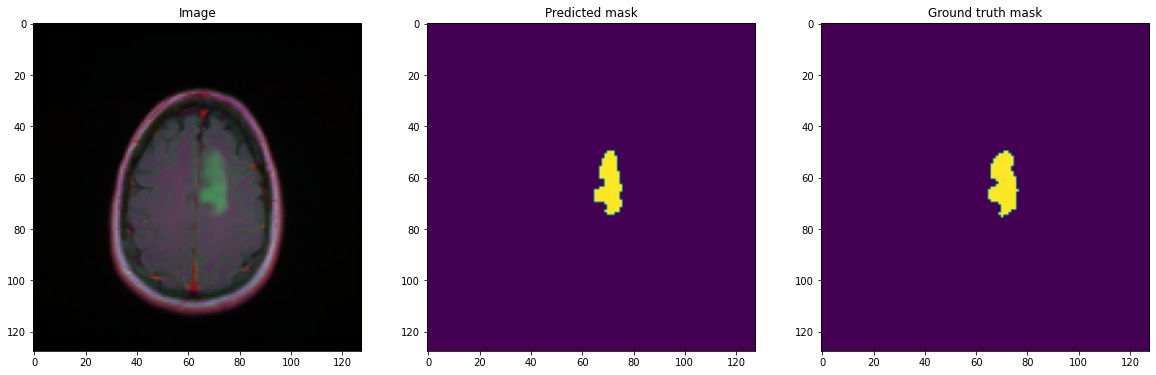

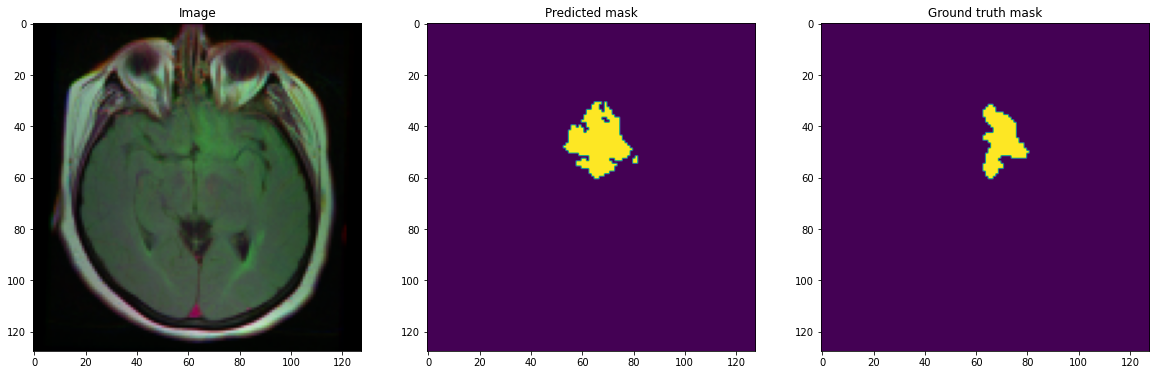

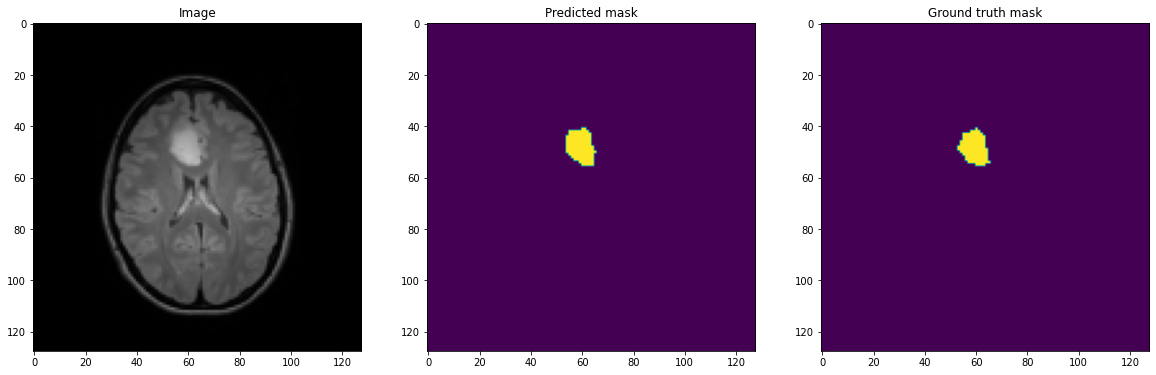

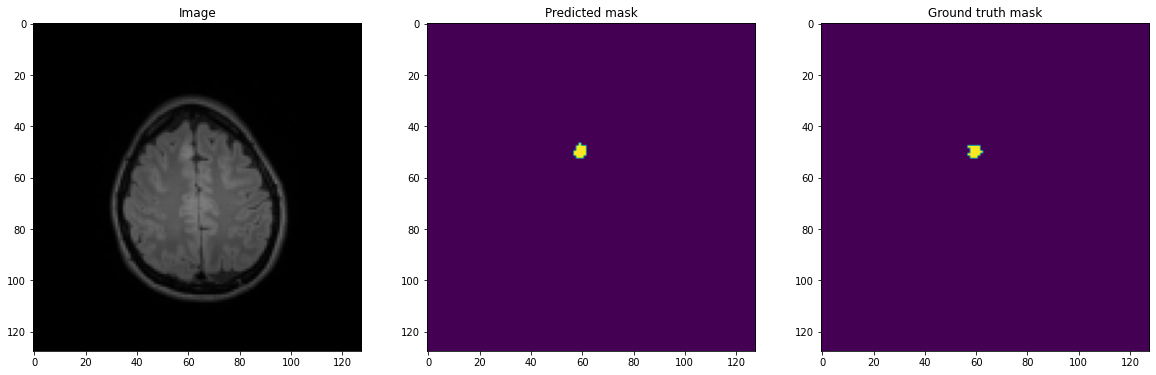

In [ ]:
for idx in range(0, 20):
    plot_images(test_images[idx], predicted_masks[idx], ground_truth_masks[idx])